In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, roc_auc_score

In [2]:
class CustomDataset(Dataset):
    def __init__(self):
        self.lepton = 0
        self.nu = 0
        self.probe_jet = 0
        self.probe_jet_constituents = 0
        self.balance_jets = 0
        self.top_labels = 0
        self.down_labels = 0
        self.direct_labels = 0
        self.track_labels = 0
    def __getitem__(self, idx):
        return self.lepton[idx], self.nu[idx], self.probe_jet[idx], self.probe_jet_constituents[idx], self.balance_jets[idx], self.top_labels[idx], self.down_labels[idx], self.direct_labels[idx], self.track_labels[idx]
    def __len__(self):
        return len(self.lepton)

In [3]:
tag="U_1M_combined"
batch_size=256

In [4]:
dset = torch.load("data/dataset_"+tag+".pt", weights_only=False)
train_dataset, test_dataset = torch.utils.data.random_split(dset, [0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [5]:
class Encoder(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(Encoder, self).__init__()
        self.pre_norm_Q = nn.LayerNorm(embed_dim)
        self.pre_norm_K = nn.LayerNorm(embed_dim)
        self.pre_norm_V = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim,num_heads=num_heads,batch_first=True, dropout=0.25)
        self.post_norm = nn.LayerNorm(embed_dim)
        self.out = nn.Linear(embed_dim,embed_dim)
    def forward(self, Query, Key, Value):
        Query = self.pre_norm_Q(Query)
        Key = self.pre_norm_K(Key)
        Value = self.pre_norm_V(Value)
        context, weights = self.attention(Query, Key, Value)
        context = self.post_norm(context)
        latent = Query + context
        tmp = F.gelu(self.out(latent))
        latent = latent + tmp
        return_weights=False
        if return_weights:
            return latent,weights
        return latent

In [6]:
class Stack(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(Stack, self).__init__()
        self.jet_trk_encoder = Encoder(embed_dim, num_heads)
        self.trk_encoder = Encoder(embed_dim, num_heads)
        self.jet_trk_cross_encoder = Encoder(embed_dim, num_heads)
        self.trk_cross_encoder = Encoder(embed_dim, num_heads)
    def forward(self, jet_embedding, jet_trk_embedding, trk_embedding):
        # Jet Track Attention
        jet_trk_embedding = self.jet_trk_encoder(jet_trk_embedding, jet_trk_embedding, jet_trk_embedding)
        # Cross Attention (Local)
        jet_embedding = self.jet_trk_cross_encoder(jet_embedding, jet_trk_embedding, jet_trk_embedding)
        # Track Attention
        trk_embedding = self.trk_encoder(trk_embedding, trk_embedding, trk_embedding)
        # Cross Attention (Global)
        jet_embedding = self.trk_cross_encoder(jet_embedding, trk_embedding, trk_embedding)
        return jet_embedding, jet_trk_embedding, trk_embedding

In [7]:
class Model2(nn.Module):  
    def __init__(self, embed_dim, num_heads):
        super(Model2, self).__init__()   
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        
        # Initiliazer
        self.lepton_initializer = nn.Linear(4, self.embed_dim)
        self.MET_initializer = nn.Linear(2, self.embed_dim)
        self.probe_jet_initializer = nn.Linear(4, self.embed_dim)
        self.probe_jet_constituent_initializer = nn.Linear(5, self.embed_dim)
        self.small_jet_initializer = nn.Linear(3, self.embed_dim)
           
        # Transformer Stack
        self.stack1 = Stack(self.embed_dim, self.num_heads)
        self.stack2 = Stack(self.embed_dim, self.num_heads)
        self.stack3 = Stack(self.embed_dim, self.num_heads)
        
        # Kinematics Regression
        self.top_regression_input = nn.Linear(self.embed_dim, self.embed_dim)
        self.top_regression = nn.Linear(self.embed_dim, 4)
        self.down_regression_input = nn.Linear(self.embed_dim, self.embed_dim)
        self.down_regression = nn.Linear(self.embed_dim, 3)

        # Direct Regression Task
        self.direct_input = nn.Linear(7, self.embed_dim)
        self.direct_regression = nn.Linear(self.embed_dim, 1)
        
        # Track Classification
        self.track_classification = nn.Linear(self.embed_dim, 3)

    def forward(self, lepton, MET, probe_jet, probe_jet_constituent, small_jet):
        
        # Feature initialization layers
        lepton_embedding = torch.unsqueeze(F.gelu(self.lepton_initializer(lepton)), dim=1)
        MET_embedding = torch.unsqueeze(F.gelu(self.MET_initializer(MET)), dim=1)
        probe_jet_embedding = torch.unsqueeze(F.gelu(self.probe_jet_initializer(probe_jet)), dim=1)
        probe_jet_constituent_embedding = F.gelu(self.probe_jet_constituent_initializer(probe_jet_constituent))
        small_jet_embedding = F.gelu(self.small_jet_initializer(small_jet))
        
        num_probe_jet = probe_jet_embedding.shape[1]
        num_constituents = probe_jet_constituent_embedding.shape[1]
        
        # Combine objects into single event tensor
        event_embedding = torch.cat([probe_jet_embedding, probe_jet_constituent_embedding, lepton_embedding, MET_embedding, small_jet_embedding], axis=1)
        
        # Transformer Stack
        probe_jet_embedding, probe_jet_constituent_embedding, event_embedding = self.stack1(probe_jet_embedding,probe_jet_constituent_embedding,event_embedding)
        probe_jet_embedding, probe_jet_constituent_embedding, event_embedding = self.stack2(probe_jet_embedding,probe_jet_constituent_embedding,event_embedding)
        #probe_jet_embedding, probe_jet_constituent_embedding, event_embedding = self.stack3(probe_jet_embedding,probe_jet_constituent_embedding,event_embedding)
        
        # Track Classificiation
        track_output = self.track_classification(probe_jet_constituent_embedding)
        
        probe_jet_embedding = torch.squeeze(probe_jet_embedding,1)
        
        # Get Top output
        top_kinematics = F.gelu(self.top_regression_input(probe_jet_embedding))
        top_kinematics = self.top_regression(top_kinematics)
        
        # Get Down output
        down_kinematics = F.gelu(self.down_regression_input(probe_jet_embedding))
        down_kinematics = F.tanh(self.down_regression(down_kinematics))
        
        # Direct Regression output
        direct_embedding = torch.cat([top_kinematics, down_kinematics], axis=1)
        direct_embedding = F.gelu(self.direct_input(direct_embedding))
        costheta = self.direct_regression(direct_embedding)

        return top_kinematics, down_kinematics, costheta, track_output

In [8]:
class Model(nn.Module):  
    def __init__(self, embed_dim, num_heads):
        super(Model, self).__init__()   
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        
        # Initiliazer
        self.lepton_initializer = nn.Linear(4, self.embed_dim)
        self.MET_initializer = nn.Linear(2, self.embed_dim)
        self.probe_jet_initializer = nn.Linear(4, self.embed_dim)
        self.probe_jet_constituent_initializer = nn.Linear(5, self.embed_dim)
        self.small_jet_initializer = nn.Linear(3, self.embed_dim)
           
        # Transformer Stack
        self.event_encoder1 = Encoder(self.embed_dim, self.num_heads)
        self.event_encoder2 = Encoder(self.embed_dim, self.num_heads)
        self.event_encoder3 = Encoder(self.embed_dim, self.num_heads)
        self.event_encoder4 = Encoder(self.embed_dim, self.num_heads)
        self.event_encoder5 = Encoder(self.embed_dim, self.num_heads)
        
        # Kinematics Regression
        self.top_regression_input = nn.Linear(self.embed_dim, self.embed_dim)
        self.top_regression = nn.Linear(self.embed_dim, 4)
        self.down_regression_input = nn.Linear(self.embed_dim, self.embed_dim)
        self.down_regression = nn.Linear(self.embed_dim, 3)

        # Direct Regression Task
        self.direct_input = nn.Linear(7, self.embed_dim)
        self.direct_regression = nn.Linear(self.embed_dim, 1)
        
        # Track Classification
        self.track_classification = nn.Linear(self.embed_dim, 3)

    def forward(self, lepton, MET, probe_jet, probe_jet_constituent, small_jet):
        
        # Feature initialization layers
        lepton_embedding = torch.unsqueeze(F.gelu(self.lepton_initializer(lepton)), dim=1)
        MET_embedding = torch.unsqueeze(F.gelu(self.MET_initializer(MET)), dim=1)
        probe_jet_embedding = torch.unsqueeze(F.gelu(self.probe_jet_initializer(probe_jet)), dim=1)
        probe_jet_constituent_embedding = F.gelu(self.probe_jet_constituent_initializer(probe_jet_constituent))
        small_jet_embedding = F.gelu(self.small_jet_initializer(small_jet))
        
        num_probe_jet = probe_jet_embedding.shape[1]
        num_constituents = probe_jet_constituent_embedding.shape[1]
        
        # Combine objects into single event tensor
        event_embedding = torch.cat([probe_jet_embedding, probe_jet_constituent_embedding, lepton_embedding, MET_embedding, small_jet_embedding], axis=1)
        
        # Event Level Attention
        event_embedding = self.event_encoder1(event_embedding,event_embedding,event_embedding)
        event_embedding = self.event_encoder2(event_embedding,event_embedding,event_embedding)
        #event_embedding = self.event_encoder3(event_embedding,event_embedding,event_embedding)
        #event_embedding = self.event_encoder4(event_embedding,event_embedding,event_embedding)
        #event_embedding = self.event_encoder5(event_embedding,event_embedding,event_embedding)
        
        # Track Classificiation
        start_idx=num_probe_jet
        end_idx=start_idx+num_constituents
        track_tensor = event_embedding[:,start_idx:end_idx]
        track_output = self.track_classification(track_tensor)
        
        # Probe jet classification
        start_idx=0
        end_idx=num_probe_jet
        probe_jet_tensor = torch.squeeze(event_embedding[:,start_idx:end_idx], dim=1)
        
        # Get Top output
        top_kinematics = F.gelu(self.top_regression_input(probe_jet_tensor))
        top_kinematics = self.top_regression(top_kinematics)
        
        # Get Down output
        down_kinematics = F.gelu(self.down_regression_input(probe_jet_tensor))
        down_kinematics = F.tanh(self.down_regression(down_kinematics))
        down_kinematics = torch.cat([F.tanh(down_kinematics[:,0:3]), down_kinematics[:,3:]], axis=1)
        
        # Direct Regression output
        direct_embedding = torch.cat([top_kinematics, down_kinematics], axis=1)
        direct_embedding = F.gelu(self.direct_input(direct_embedding))
        costheta = self.direct_regression(direct_embedding)

        return top_kinematics, down_kinematics, costheta, track_output

In [9]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

GPU Available:  True
cuda:0


In [10]:
model = Model2(32,4).to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.0001)

MSE_loss_fn = nn.MSELoss()
CCE_loss_fn = nn.CrossEntropyLoss()

In [11]:
print("Trainable Parameters :", sum(p.numel() for p in model.parameters() if p.requires_grad))

Trainable Parameters : 69899


In [12]:
print("Number of Training Events: ", len(train_loader)*batch_size)

Number of Training Events:  167168


In [13]:
for lepton, MET, probe_jet, constituents, small_jet, top_labels, down_labels, direct_labels, track_labels in train_loader:
    top_pred, down_pred, direct_pred, trk_output = model(lepton.to(device), MET.to(device), probe_jet.to(device), constituents.to(device), small_jet.to(device))
    break

In [14]:
def train(model, optimizer, train_loader, val_loader, epochs=40):
    
    combined_history = []
    
    for e in range(epochs):
        model.train()
        cumulative_loss_train = 0
        num_train = len(train_loader)

        for lepton, MET, probe_jet, constituents, small_jet, top_labels, down_labels, direct_labels, track_labels in train_loader:
            optimizer.zero_grad()
            
            top_pred, down_pred, direct_pred, trk_output = model(lepton.to(device), MET.to(device), probe_jet.to(device), constituents.to(device), small_jet.to(device))
                        
            top_loss      = MSE_loss_fn(top_pred, top_labels.to(device))
            down_loss     = MSE_loss_fn(down_pred, down_labels.to(device))
            costheta_loss = MSE_loss_fn(direct_pred, direct_labels.to(device))
            track_loss    = CCE_loss_fn(trk_output, track_labels.to(device))
            
            alpha = 0
            beta  = 1
            gamma = 0
            delta = 0
            loss  = alpha*top_loss + beta*down_loss + gamma*costheta_loss + delta*track_loss
            
            loss.backward()
            optimizer.step()
            
            cumulative_loss_train+=loss.detach().cpu().numpy().mean()
            
        cumulative_loss_train = cumulative_loss_train / num_train
        
        model.eval()
        cumulative_loss_val = 0
        num_val = len(val_loader)
        for lepton, MET, probe_jet, constituents, small_jet, top_labels, down_labels, direct_labels, track_labels in val_loader:
            top_pred, down_pred, direct_pred, trk_output = model(lepton.to(device), MET.to(device), probe_jet.to(device), constituents.to(device), small_jet.to(device))
            
            top_loss      = MSE_loss_fn(top_pred, top_labels.to(device))
            down_loss     = MSE_loss_fn(down_pred, down_labels.to(device))
            costheta_loss = MSE_loss_fn(direct_pred, direct_labels.to(device))
            track_loss    = CCE_loss_fn(trk_output, track_labels.to(device))
            
            loss  = alpha*top_loss + beta*down_loss + gamma*costheta_loss + delta*track_loss

            cumulative_loss_val+=loss.detach().cpu().numpy().mean()
        
        cumulative_loss_val = cumulative_loss_val / num_val
        
        combined_history.append([cumulative_loss_train, cumulative_loss_val])

        if e%1==0:
            print('Epoch:',e+1,'\tTrain Loss:',round(cumulative_loss_train,6),'\tVal Loss:',round(cumulative_loss_val,6))
            
    return np.array(combined_history)

In [15]:
history = train(model, optimizer, train_loader, test_loader, epochs=20)

Epoch: 1 	Train Loss: 0.33431 	Val Loss: 0.333791
Epoch: 2 	Train Loss: 0.33357 	Val Loss: 0.333616
Epoch: 3 	Train Loss: 0.333507 	Val Loss: 0.333535
Epoch: 4 	Train Loss: 0.333474 	Val Loss: 0.333481
Epoch: 5 	Train Loss: 0.333454 	Val Loss: 0.33345
Epoch: 6 	Train Loss: 0.333441 	Val Loss: 0.333428
Epoch: 7 	Train Loss: 0.333422 	Val Loss: 0.33342
Epoch: 8 	Train Loss: 0.333424 	Val Loss: 0.333407
Epoch: 9 	Train Loss: 0.333415 	Val Loss: 0.333403
Epoch: 10 	Train Loss: 0.333409 	Val Loss: 0.333391
Epoch: 11 	Train Loss: 0.333409 	Val Loss: 0.333386
Epoch: 12 	Train Loss: 0.333401 	Val Loss: 0.333387
Epoch: 13 	Train Loss: 0.333398 	Val Loss: 0.333379
Epoch: 14 	Train Loss: 0.333389 	Val Loss: 0.333388
Epoch: 15 	Train Loss: 0.333389 	Val Loss: 0.333382
Epoch: 16 	Train Loss: 0.333387 	Val Loss: 0.333384
Epoch: 17 	Train Loss: 0.33338 	Val Loss: 0.333385
Epoch: 18 	Train Loss: 0.33338 	Val Loss: 0.333384
Epoch: 19 	Train Loss: 0.333373 	Val Loss: 0.333384
Epoch: 20 	Train Loss: 0.33

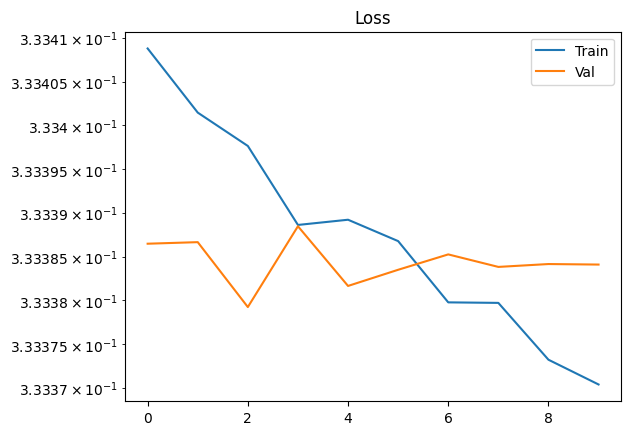

In [16]:
plt.figure()
plt.plot(history[10:,0], label="Train")
plt.plot(history[10:,1], label="Val")
plt.title('Loss')
plt.legend()
plt.yscale('log')
plt.show()

In [17]:
top_feats=4
pred_top = np.array([]).reshape(0,top_feats)
true_top = np.array([]).reshape(0,top_feats)

down_feats=3
pred_down = np.array([]).reshape(0,down_feats)
true_down = np.array([]).reshape(0,down_feats)

direct_feats=1
pred_costheta = np.array([]).reshape(0,direct_feats)
true_costheta = np.array([]).reshape(0,direct_feats)

for lepton, MET, probe_jet, constituents, small_jet, top_labels, down_labels, direct_labels, track_labels in test_loader:
    top_pred, down_pred, direct_pred, trk_output = model(lepton.to(device), MET.to(device), probe_jet.to(device), constituents.to(device), small_jet.to(device))
    
    pred_top = np.vstack((pred_top,top_pred.detach().cpu().numpy()))
    true_top = np.vstack((true_top,top_labels.detach().cpu().numpy()))
    
    pred_down = np.vstack((pred_down,down_pred.detach().cpu().numpy()))
    true_down = np.vstack((true_down,down_labels.detach().cpu().numpy()))
    
    pred_costheta = np.vstack((pred_costheta,direct_pred.detach().cpu().numpy()))
    true_costheta = np.vstack((true_costheta,direct_labels.detach().cpu().numpy()))

In [18]:
do_PlotTop=False
do_PlotDown=True
do_PlotDirect=False

In [19]:
def validate_predictions(true, pred, var_names):
    num_feats = len(var_names)
    for i in range(num_feats):
        if np.min(true[:,i])>0:
            var_range = (0, np.mean(true[:,i])+5*np.std(true[:,i]))
        else:
            var_range = (np.mean(true[:,i])-5*np.std(true[:,i]), np.mean(true[:,i])+5*np.std(true[:,i]))
        plt.figure()
        plt.hist(np.ravel(true[:,i]),histtype='step',color='r',label='True Distribution',bins=50,range=var_range)
        plt.hist(np.ravel(pred[:,i]),histtype='step',color='b',label='Predicted Distribution',bins=50,range=var_range)
        plt.title("Predicted Ouput Distribution using Attention Model")
        plt.legend()
        plt.yscale('log')
        plt.xlabel(var_names[i],loc='right')
        #plt.savefig(out_dir+"/pred_1d_"+feats[i]+".png")
        plt.show()
        plt.close()

        #plt.figure()
        fig, ax = plt.subplots()
        plt.title("Ouput Distribution using Attention Model")
        h = ax.hist2d(np.ravel(pred[:,i]),np.ravel(true[:,i]), bins=100,norm=mcolors.LogNorm(),range=(var_range,var_range))
        #fig.colorbar(h[3], ax=ax)
        plt.xlabel('Predicted '+var_names[i],loc='right')
        plt.ylabel('True '+var_names[i],loc='top')
        diff = var_range[1] - var_range[0]
        plt.text(var_range[1]-0.3*diff,var_range[0]+0.2*diff,"$R^2$ value: "+str(round(r2_score(np.ravel(true[:,i]),np.ravel(pred[:,i])),3)),backgroundcolor='r',color='k')
        #print("R^2 value: ", round(r2_score(true_labels[:,i],predicted_labels[:,i]),3))
        #plt.savefig(out_dir+"/pred_2d_"+feats[i]+".png")
        plt.show()
        plt.close()

In [20]:
if do_PlotTop:
    validate_predictions(true_top, pred_top, ["top_px", "top_py", "top_pz", "top_e"])

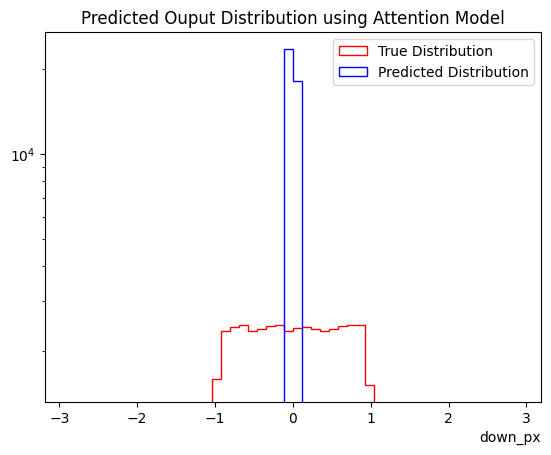

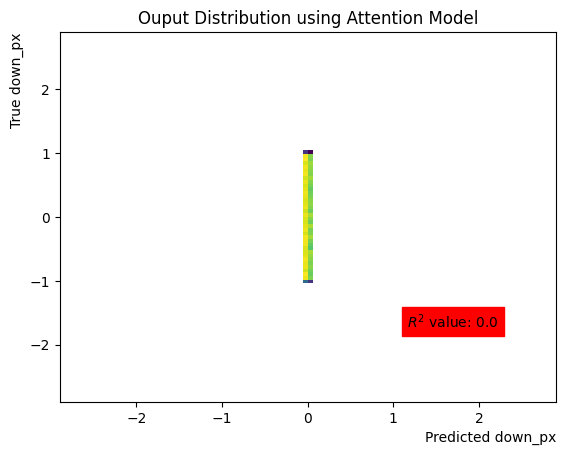

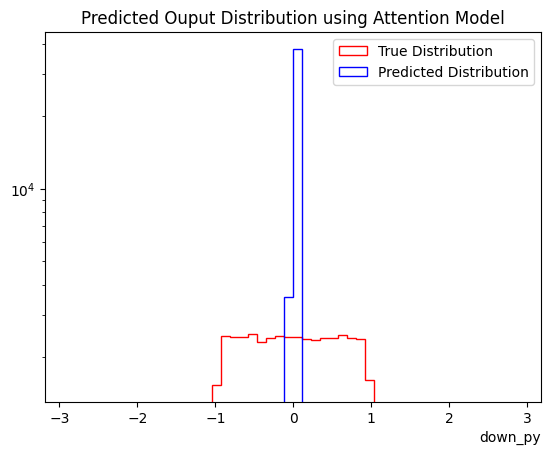

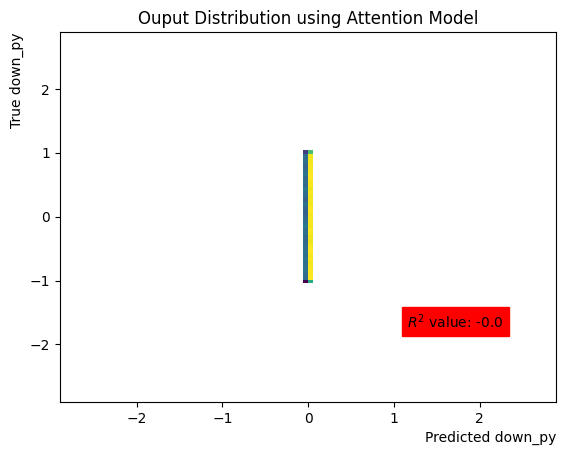

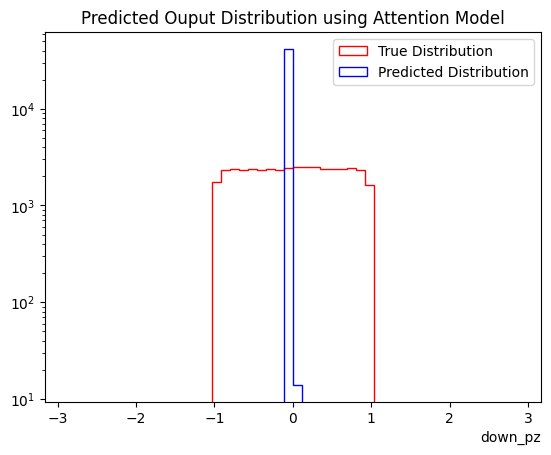

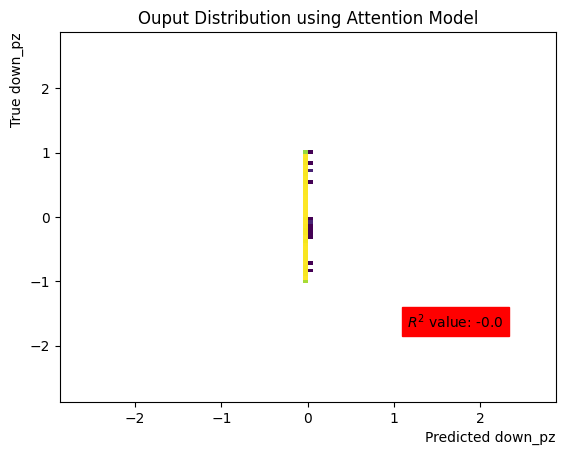

In [21]:
if do_PlotDown:
    validate_predictions(true_down, pred_down, ["down_px", "down_py", "down_pz"])

In [22]:
if do_PlotDirect:
    validate_predictions(true_costheta, pred_costheta, ["costheta"])